In [8]:
from math import degrees
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [9]:
datafile = 'data_gaia_added/L328_pol_full_mod2.csv'

data = pd.read_csv(datafile,delimiter=',')
data = data[(data['P']/data['eP']) > 2]
data = data[data['distance_parallax']/1000 < 4]
data = data[0<data['distance_parallax']/1000]
ra = np.array(data['ra'])
dec = np.array(data['dec'])
PA = np.array(data['PA'])
ePA = np.array(data['ePA'])

In [10]:
def Calc_l(ra1,dec1,ra2,dec2):
    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute


local_PA_minima = 125

PA_mod = PA -180*(PA>local_PA_minima)*np.ones_like(PA)
# PA_mod = PA
distance_mat = np.zeros((ra.shape[0],ra.shape[0]))
PolAngleSqr_diff = np.zeros((ra.shape[0],ra.shape[0]))
ePolAngleSqr_mat = np.zeros((ra.shape[0],ra.shape[0]))

for i in range(ra.shape[0]):
    for j in range(i):
        distance_mat[i,j] = Calc_l(ra[i],dec[i],ra[j],dec[j])
        if (abs(PA_mod[i] - PA_mod[j])<90):
            PolAngleSqr_diff[i,j] = (PA_mod[i] - PA_mod[j])**2
            ePolAngleSqr_mat[i,j] = ePA[i]**2+ePA[j]**2
            distance_mat[i,j] = Calc_l(ra[i],dec[i],ra[j],dec[j])
            

In [11]:
struc_func = []
error_func = []
error1_func = []
count_array = []
l_bins_length = 1.5
l_bins = np.arange(0,np.max(distance_mat)+l_bins_length,l_bins_length)
l_bins_centre = (l_bins[:-1] + l_bins[1:])/2

for k in range(l_bins.shape[0]-1):
    count = 0
    temp_PolAngle = []
    temp_ePolAngle = []
    for i in range(PolAngleSqr_diff.shape[0]):
        for j in range(i):
            if l_bins[k]< distance_mat[i,j]<=l_bins[k+1]:
                count += 1
                temp_PolAngle.append(PolAngleSqr_diff[i,j])
                temp_ePolAngle.append(ePolAngleSqr_mat[i,j])
            else:
                pass
    if count != 0:
        temp_PolAngle = np.array(temp_PolAngle)
        temp_ePolAngle = np.array(temp_ePolAngle)
        std_PA = np.mean(temp_PolAngle) - np.mean(temp_ePolAngle)
        mean_PA = np.sqrt(std_PA)
        a = np.sqrt(temp_ePolAngle)
        err_PA1 = np.std(a)
        err_PA = err_PA1/np.sqrt(count)
        struc_func.append(mean_PA)
        error_func.append(err_PA)
        error1_func.append(err_PA1)
        count_array.append(count)
    else:
        struc_func.append(0)
        error1_func.append(0)
        error_func.append(0)


struc_func = np.array(struc_func)
error_func = np.array(error_func)
error1_func = np.array(error1_func)
struc_func = np.sqrt(struc_func**2 - error_func**2)


[ 6.88851986 25.94944107]


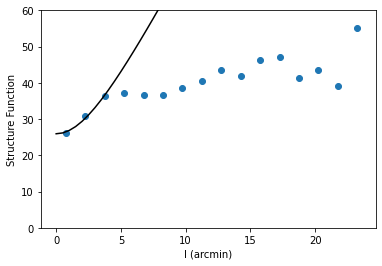

In [23]:
def fitfun(l, m, b):
  y = np.sqrt(b**2 + (m**2) * (l**2))
  return y



popt, pcov = curve_fit(fitfun, l_bins_centre[0:3], struc_func[0:3])
line = np.arange(0,np.max(l_bins),0.5)
fitted_line = fitfun(line,popt[0],popt[1])

b = popt[1]
b1 = popt[1]*math.pi/180
perr = np.sqrt(np.diag(pcov))
Bmag = b1/(math.sqrt(2-(b1**2)))
print(b, b1, Bmag,perr)
print(popt)
plt.scatter(l_bins_centre,struc_func)
plt.plot(line,fitted_line,'k')
plt.ylim(0,60)
plt.xlabel('l (arcmin)')
plt.ylabel('Structure Function')
plt.show()